In [1]:
import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models

In [2]:
train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'


In [3]:
def load_data(traindir,testdir,valdir):
    data_transforms=transforms.Compose([transforms.RandomCrop(64),transforms.Resize(224),transforms.ToTensor()])
    train_data = datasets.ImageFolder(traindir,transform = data_transforms,)
    test_data = datasets.ImageFolder(testdir,transform = data_transforms,)
    val_data = datasets.ImageFolder(valdir,transform = data_transforms,)
    num_train = len(train_data)
    num_test = len(test_data)
    num_val = len(val_data)
    indices_train = list(range(num_train))
    indices_val = list(range(num_val))
    indices_test = list(range(num_test))
    from torch.utils.data.sampler import SubsetRandomSampler
#     train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(indices_train)
    test_sampler = SubsetRandomSampler(indices_test)
    val_sampler = SubsetRandomSampler(indices_val)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=256)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=256)
    valoader = torch.utils.data.DataLoader(val_data,
                   sampler=val_sampler, batch_size=256)
    return trainloader, valoader,testloader
    
    
trainloader, valoader,testloader = load_data(train_dir,test_dir,val_dir )
print(valoader.dataset.classes)


['centred', 'hexagonal', 'noise', 'oblique', 'rectangular', 'square']


In [5]:
device = torch.device("cuda"if torch.cuda.is_available()
                     else "cpu")


In [6]:
model = models.resnet50(pretrained=True)
# print(model)

In [7]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 6),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.02)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,patience=4)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
       
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = (top_class == labels.view(*top_class.shape))
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/20.. Train loss: 25.510.. Test loss: 4.160.. Test accuracy: 0.329
Epoch 1/20.. Train loss: 1.233.. Test loss: 4.764.. Test accuracy: 0.278
Epoch 1/20.. Train loss: 0.631.. Test loss: 1.554.. Test accuracy: 0.312
Epoch 1/20.. Train loss: 0.577.. Test loss: 1.846.. Test accuracy: 0.351
Epoch 1/20.. Train loss: 0.568.. Test loss: 0.889.. Test accuracy: 0.542
Epoch 1/20.. Train loss: 0.521.. Test loss: 0.587.. Test accuracy: 0.652
Epoch 2/20.. Train loss: 0.550.. Test loss: 0.544.. Test accuracy: 0.649
Epoch 2/20.. Train loss: 0.546.. Test loss: 0.528.. Test accuracy: 0.655
Epoch 2/20.. Train loss: 0.524.. Test loss: 0.484.. Test accuracy: 0.677


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

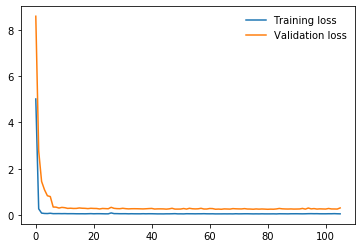

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()